In [ ]:
# Import library that needed for colab
from google.colab import drive # colab only
from google.colab import files # colab only

import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import zipfile
import pandas as pd
import random
import re
import seaborn as sns

from PIL import Image

from tqdm import tqdm

from shutil import move
from shutil import copy
from shutil import make_archive
from shutil import rmtree

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import lite, cast, float32
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, InceptionV3, \
                                           VGG19, Xception, DenseNet121, DenseNet201, ResNet152V2, EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix

# Introduction

In [ ]:
# Downloading the datasets using Roboflow API
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="lV058ERNk7TC2eroU6tH")
project = rf.workspace("material-identification").project("garbage-classification-3")
dataset = project.version(2).download("tensorflow")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.8 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=e96b7f2a04451ef2471836bc345c26d168b176ce74c06a856fe63f43ab3dd2f3
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to GARBAGE-CLASSIFICATION-3-2 in tensorflow:: 100%|██████████| 10472/10472 [00:02<00:00, 3759.10it/s]


# Dataset

In [ ]:
# os.mkdir(f'{os.getcwd()}/GarbageClassificationDataset')

def move_img(SOURCE, DEST, SIZE=299):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
  for filename in files:
    if '.jpg' in filename:
      move(f"{SOURCE}/{filename}",f"{DEST}/{filename}")
  print(len(files))

base_path = f'{os.getcwd()}/GARBAGE-CLASSIFICATION-3-2/'
for dir in os.listdir(base_path):
  path_dir = os.path.join(base_path, dir)
  if os.path.isdir(path_dir):
    move_img(f"{path_dir}/", f'{os.getcwd()}/GarbageClassificationDataset/')

1043
7325
2099


In [ ]:
def len_files(SOURCE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
  print(len(files))

len_files(f'{os.getcwd()}/GarbageClassificationDataset/')

10464


In [ ]:
# Dictionary to save our 6 classes
categories = ['biodegradable', 'plastic', 'paper', 'metal', 'cardboard', 'glass']

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for filenames in os.listdir(f'{os.getcwd()}/GarbageClassificationDataset/'):
    filenames_list.append(filenames)
    pattern = re.compile(r"[A-Za-z]+", re.IGNORECASE).match(filenames).group()
    categories_list += [pattern]

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = df.sample(frac=1).reset_index(drop=True)

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  10464


In [ ]:
df.head()

,filename,category
0,biodegradable1976_jpeg.rf.9aa4f47e2b785b9b80bb...,biodegradable
1,biodegradable32_jpg.rf.f398955d99905bfdcdc3f45...,biodegradable
2,paper979_jpg.rf.bfab45e9cb6ed8beddca6b5438e3d6...,paper
3,metal302_jpg.rf.4d08f269d51159b05db74462f195af...,metal
4,biodegradable1856_jpeg.rf.0ded6dad7b142bee6fb6...,biodegradable


## Images example in dataset

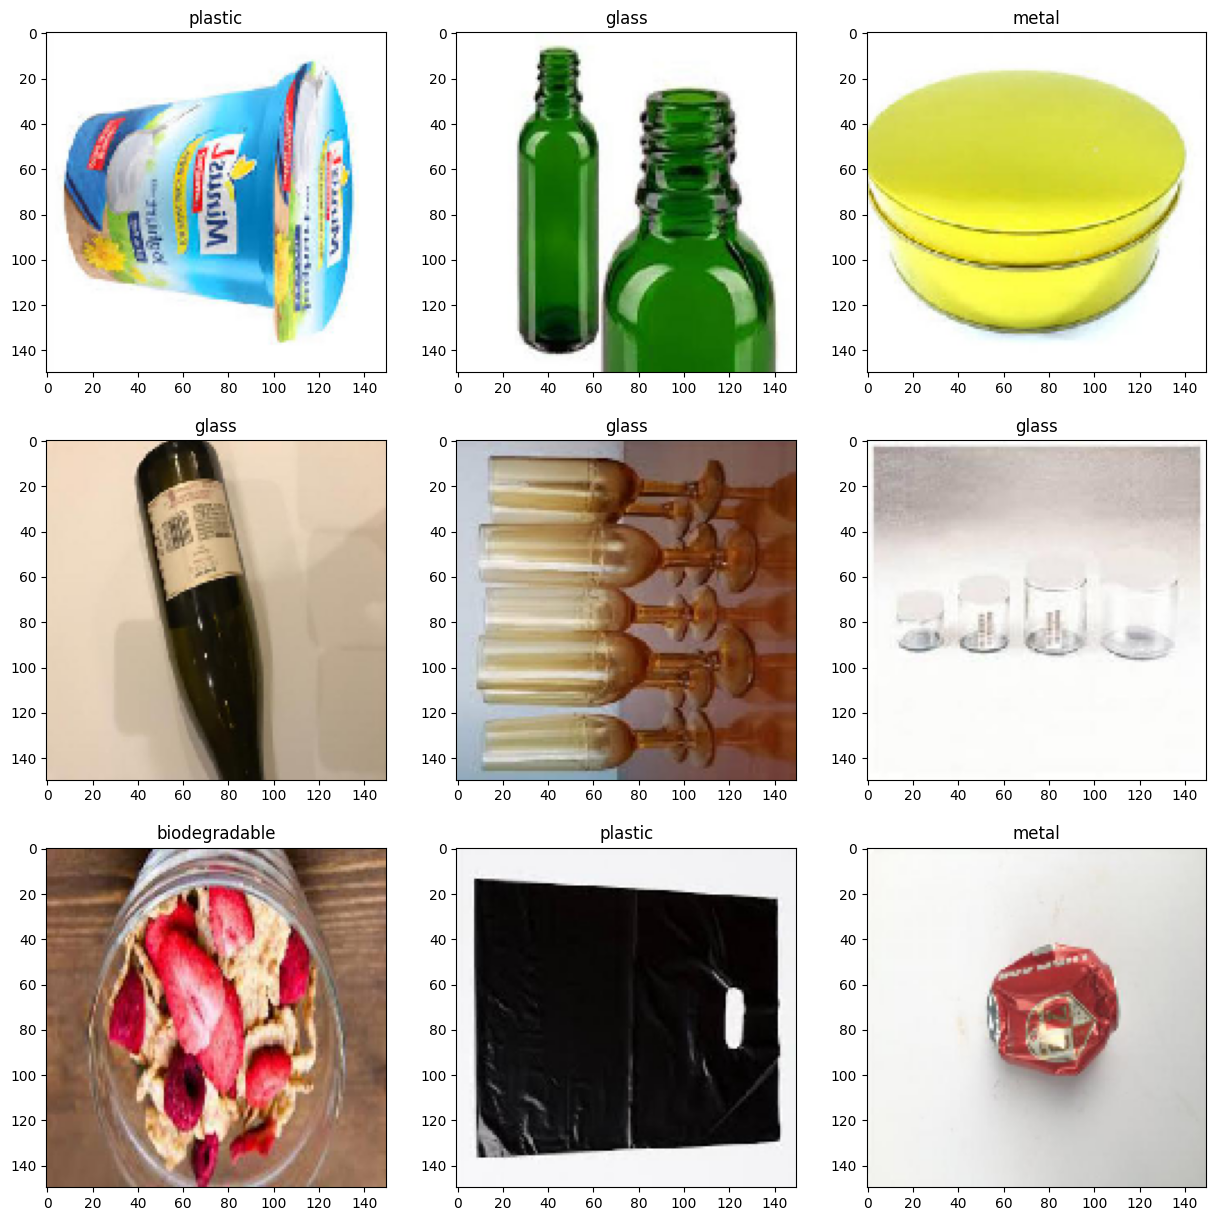

In [ ]:
# see sample image, you can run the same cell again to get a different image
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = tf.keras.utils.load_img(f'{os.getcwd()}/GarbageClassificationDataset/{sample["filename"]}', target_size=(150, 150))
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

## Comparison total images per class

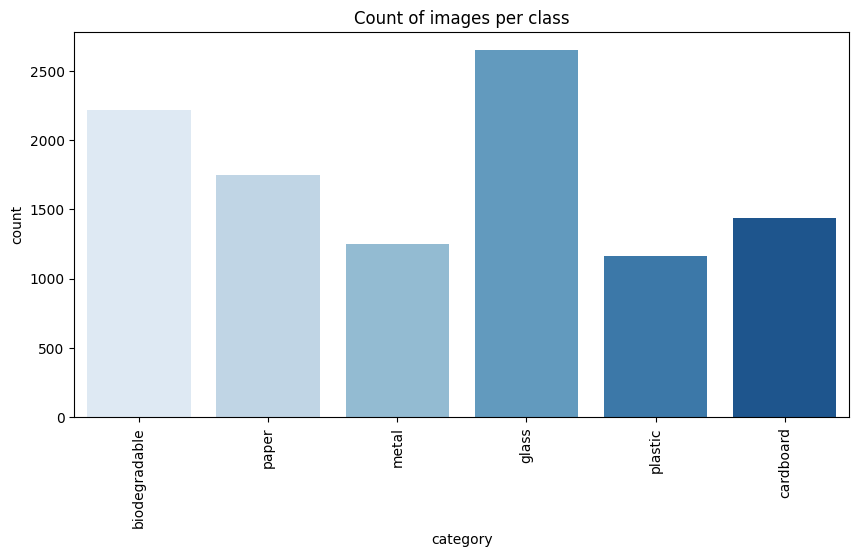

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Count of images per class')
plt.show()

In [ ]:
# We first split the data into two sets and then split the validate_df to two sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('train size = ', train_df.shape[0] , 'validate size = ', val_df.shape[0], 'test size = ', test_df.shape[0])

train size =  8371 validate size =  1046 test size =  1047


In [ ]:
train_df

,filename,category
0,metal307_jpg.rf.564f3da871252062ea9664f0de489c...,metal
1,metal674_jpg.rf.be85916c9dacf828d1455a6dc487f2...,metal
2,paper1700_jpeg.rf.dddb9e90457b45e4994c3c989de5...,paper
3,glass1827_jpg.rf.b7c89da658f581dfd22108c836df0...,glass
4,biodegradable1783_jpeg.rf.954277d228007f78d961...,biodegradable
...,...,...
8366,glass264_jpg.rf.03a6197713d6140dd2dafde14e3b5a...,glass
8367,paper777_jpg.rf.7860914b7eedd1525bb008b274745f...,paper
8368,plastic897_jpg.rf.565039395d7f0c429c48ffbeedfa...,plastic
8369,biodegradable821_jpg.rf.a32184d8d71504f8d14f48...,biodegradable


# Augmentation

In [ ]:
base_path = f'{os.getcwd()}/GarbageClassificationDataset/'

batch_size = 64
size = 256
seed = 42
epoch = 50

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=(size, size),
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=(size, size),
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=(size, size),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 8371 validated image filenames belonging to 6 classes.
Found 1046 validated image filenames belonging to 6 classes.
Found 1047 validated image filenames belonging to 6 classes.


In [ ]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: ' + str(classes))
num_classes  = len(classes)

Classes: ['biodegradable', 'cardboard', 'glass', 'metal', 'paper', 'plastic']


# CNN Model

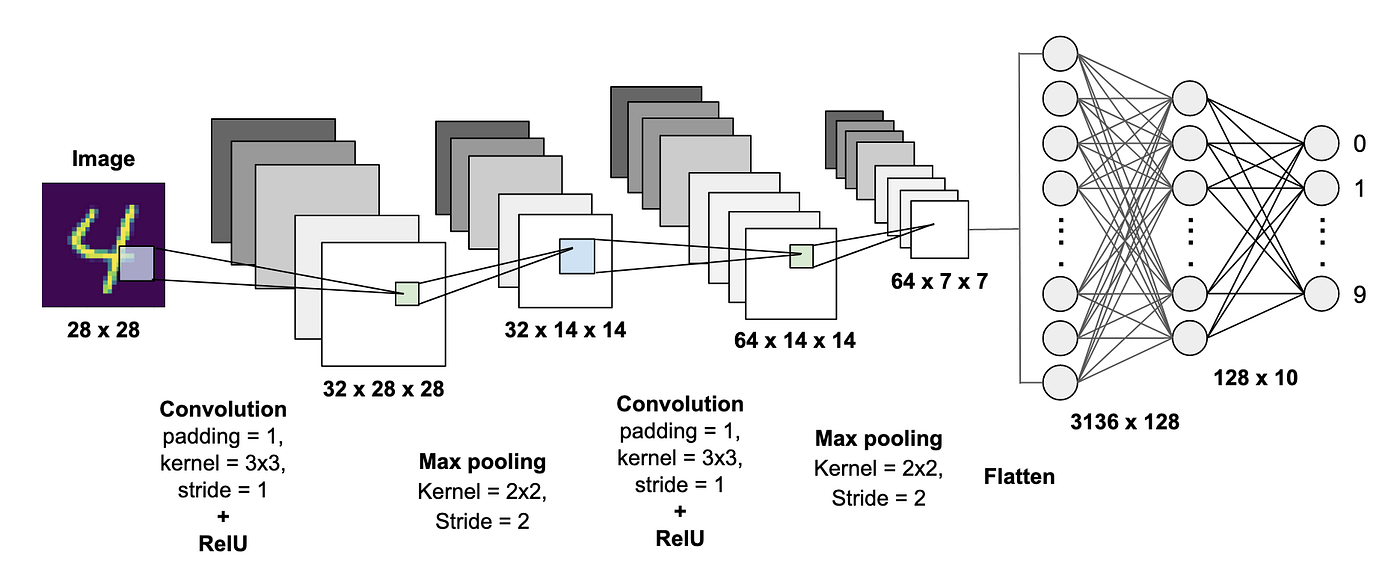

In [ ]:
# Define the model architecture
model = Sequential([
    # Convolutional layer with 4th layers, each of size 3x3 with respective filter, and ReLU activation
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(size, size, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    # Flatten the output from the previous layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    # Output layer with 12 units and softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

## Training the CNN Model

In [ ]:
epochs = 30

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/30
130/130 [==============================] - ETA: 0s - loss: 1.5554 - accuracy: 0.3675
Epoch 1: val_loss improved from inf to 1.31384, saving model to model.h5
130/130 [==============================] - 65s 385ms/step - loss: 1.5554 - accuracy: 0.3675 - val_loss: 1.3138 - val_accuracy: 0.4854
Epoch 2/30
130/130 [==============================] - ETA: 0s - loss: 1.2954 - accuracy: 0.5033
Epoch 2: val_loss improved from 1.31384 to 1.17850, saving model to model.h5
130/130 [==============================] - 48s 370ms/step - loss: 1.2954 - accuracy: 0.5033 - val_loss: 1.1785 - val_accuracy: 0.5400
Epoch 3/30
130/130 [==============================] - ETA: 0s - loss: 1.1668 - accuracy: 0.5665
Epoch 3: val_loss improved from 1.17850 to 1.06477, saving model to model.h5
130/130 [==============================] - 53s 409ms/step - loss: 1.1668 - accuracy: 0.5665 - val_loss: 1.0648 - val_accuracy: 0.6035
Epoch 4/30
130/130 [==============================] - ETA: 0s - loss: 1.0595 - accu

## CNN Model Evaluation

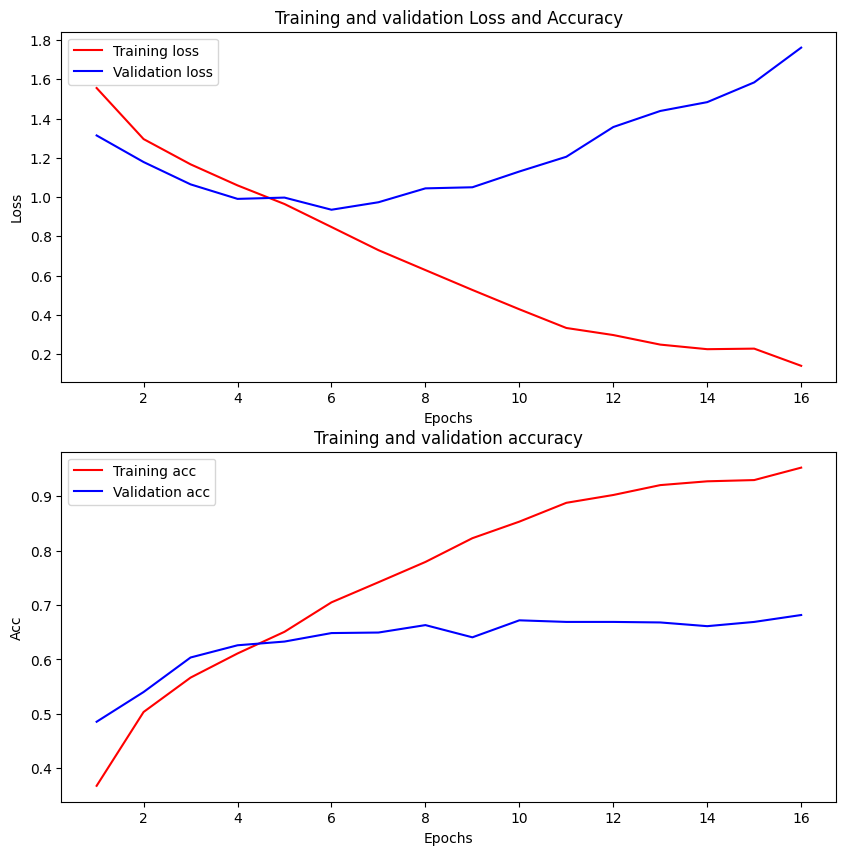

In [ ]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, color='r', label='Training loss')
plt.plot(epochs_x, val_loss_values, color='b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, color='r', label='Training acc')
plt.plot(epochs_x, val_acc_values, color='b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
# model = load_model('../input/keras-simple-cnn-gargabe-classification/model.h5')
model = load_model('model.h5')

In [ ]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

17/17 [==============================] - 6s 350ms/step - loss: 1.7548 - accuracy: 0.6836
Val loss: 1.7548303604125977
Val accuracy: 0.6835563778877258


In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1047/1047 [==============================] - 8s 6ms/step - loss: 0.9370 - accuracy: 0.6543
Test loss: 0.9369794726371765
Test accuracy: 0.6542502641677856


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

1047/1047 [==============================] - 6s 6ms/step
Classification Report
               precision    recall  f1-score   support

biodegradable       0.79      0.86      0.82       228
    cardboard       0.82      0.71      0.76       146
        glass       0.75      0.62      0.68       245
        metal       0.47      0.35      0.41       130
        paper       0.45      0.73      0.56       177
      plastic       0.70      0.48      0.57       121

     accuracy                           0.65      1047
    macro avg       0.66      0.63      0.63      1047
 weighted avg       0.68      0.65      0.65      1047



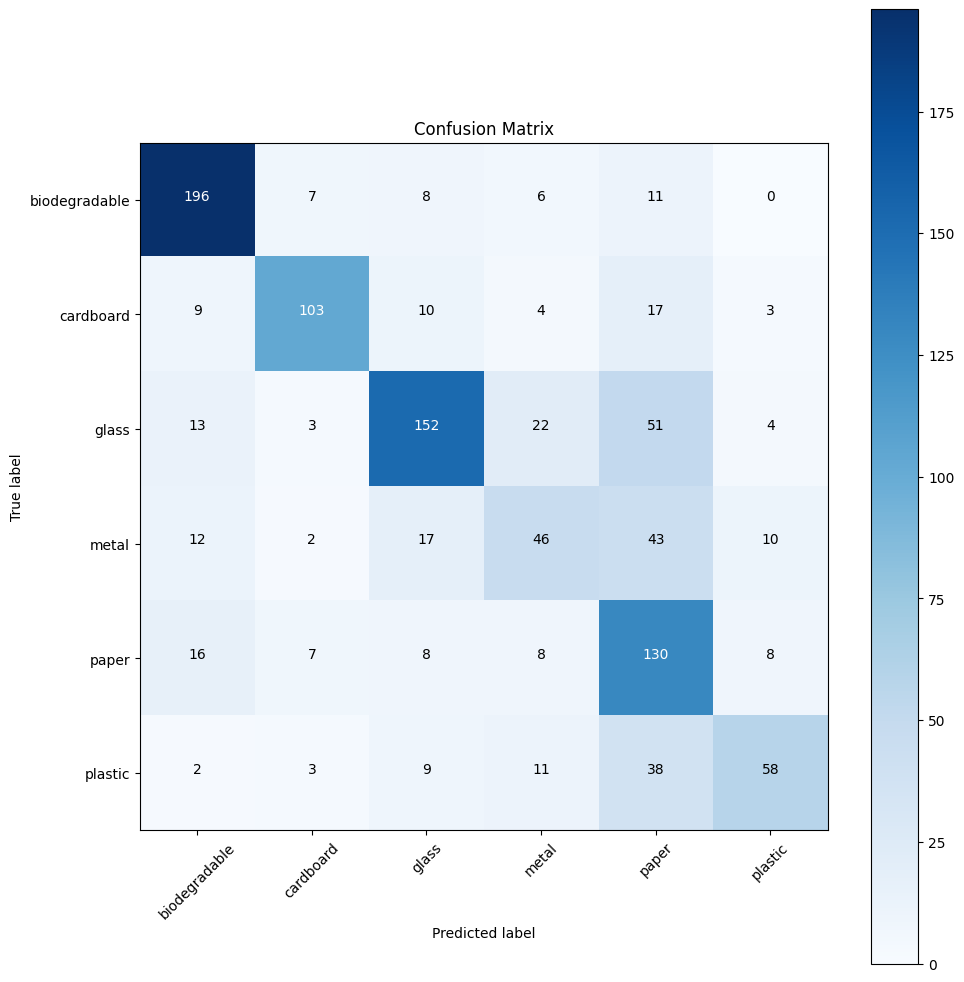

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Xception Model

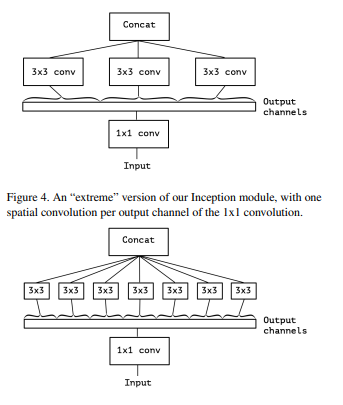

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(size, size, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')
])

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

83683744/83683744 [==============================] - 3s 0us/step


## Training the Xception Model

In [ ]:
epochs = 30

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model_Xception.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/30
130/130 [==============================] - ETA: 0s - loss: 0.5314 - accuracy: 0.8297
Epoch 1: val_loss improved from inf to 0.31927, saving model to model_Xception.h5
130/130 [==============================] - 80s 536ms/step - loss: 0.5314 - accuracy: 0.8297 - val_loss: 0.3193 - val_accuracy: 0.8838
Epoch 2/30
130/130 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.9469
Epoch 2: val_loss did not improve from 0.31927
130/130 [==============================] - 60s 463ms/step - loss: 0.1516 - accuracy: 0.9469 - val_loss: 0.3444 - val_accuracy: 0.8906
Epoch 3/30
130/130 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9760
Epoch 3: val_loss did not improve from 0.31927
130/130 [==============================] - 60s 463ms/step - loss: 0.0738 - accuracy: 0.9760 - val_loss: 0.3969 - val_accuracy: 0.8848
Epoch 4/30
130/130 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9895
Epoch 4: val_loss did not improve from

## Xception Model Evaluation

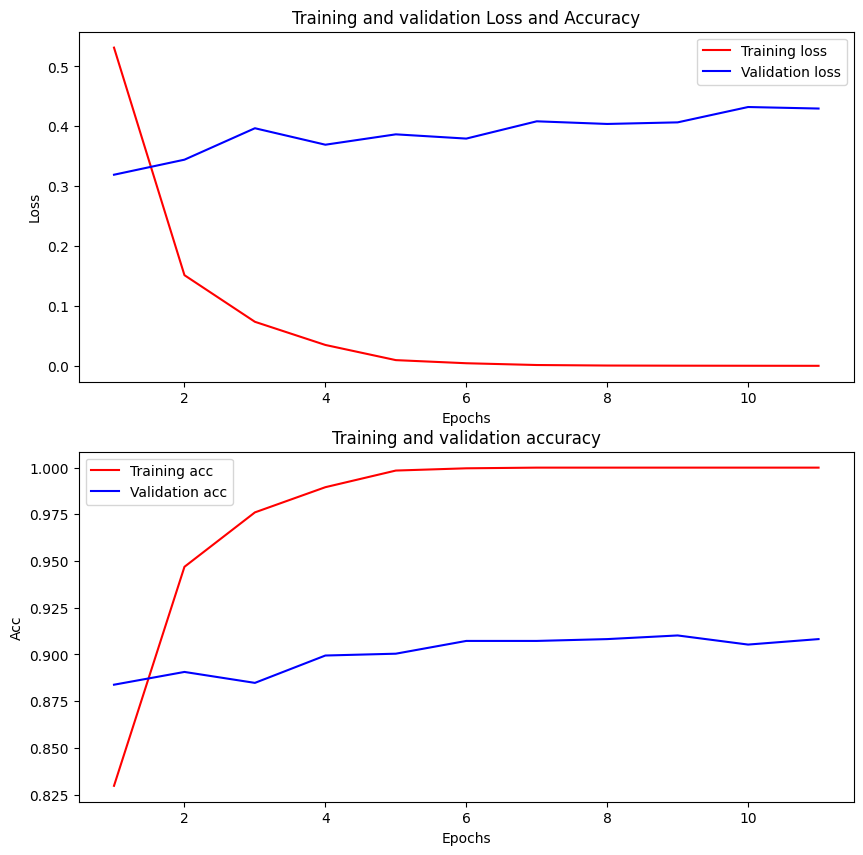

In [ ]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, color='r', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, color='r', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
model = load_model('model_Xception.h5')

In [ ]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

17/17 [==============================] - 9s 462ms/step - loss: 0.3248 - accuracy: 0.8834
Val loss: 0.3248063027858734
Val accuracy: 0.8833652138710022


In [ ]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1047/1047 [==============================] - 13s 12ms/step - loss: 0.3180 - accuracy: 0.8825
Test loss: 0.31798699498176575
Test accuracy: 0.8825215101242065


1047/1047 [==============================] - 11s 10ms/step
Classification Report
               precision    recall  f1-score   support

biodegradable       0.97      0.97      0.97       228
    cardboard       0.83      0.97      0.89       146
        glass       0.89      0.89      0.89       245
        metal       0.91      0.82      0.86       130
        paper       0.85      0.84      0.85       177
      plastic       0.79      0.74      0.76       121

     accuracy                           0.88      1047
    macro avg       0.87      0.87      0.87      1047
 weighted avg       0.88      0.88      0.88      1047



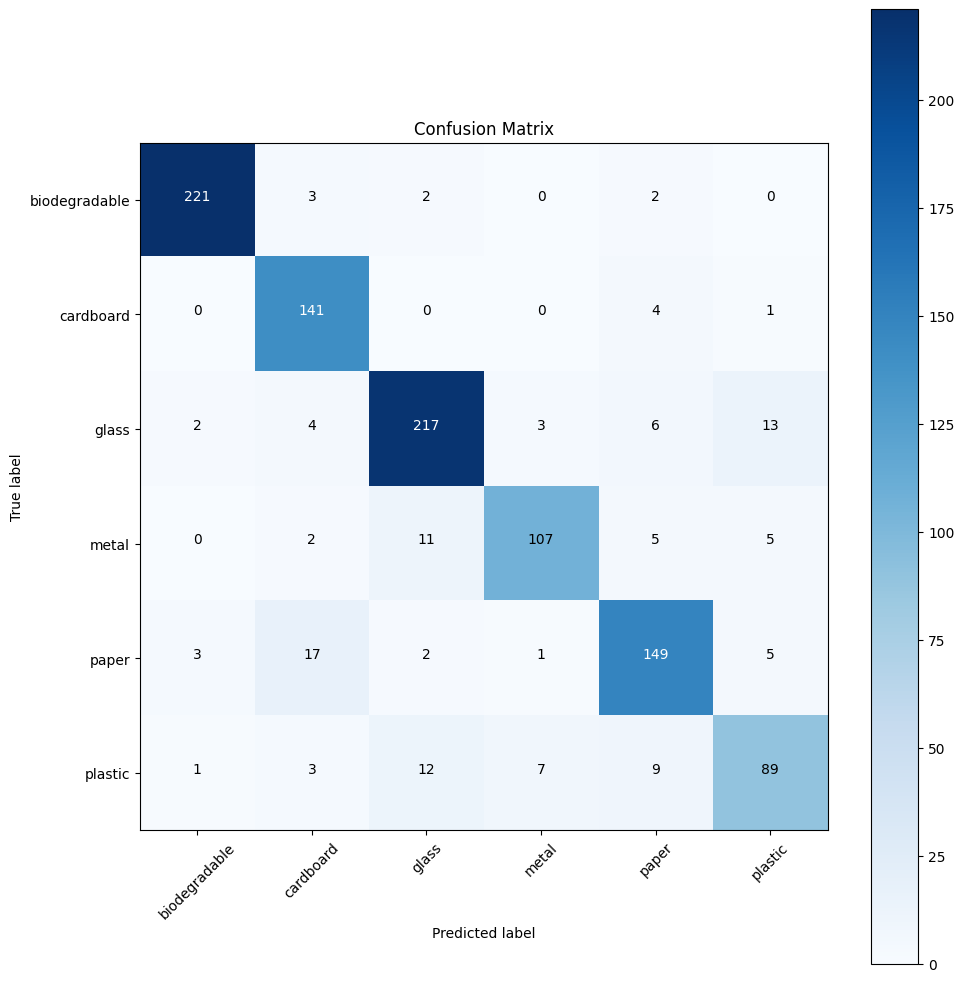

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp model.h5 /content/drive/MyDrive
!cp model_Xception.h5 /content/drive/MyDrive

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])

In [ ]:
# test some picture here

# this is for general testing
imgs = []

random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = tf.keras.utils.load_img(base_path +sample['filename'], target_size=(256, 256))
img = tf.keras.utils.img_to_array(randomimage)
img = img.astype(np.float32) / 255
print(sample['filename'])
plt.imshow(randomimage)
imgs.append(img)
imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)

print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {categories[pred[0]]}")

In [ ]:
def to_tflite(path, tflite_filename, optimizations):

    model = load_model(path)
    converter = lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [lite.Optimize.DEFAULT]

    tflite_model = converter.convert()

    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    return tflite_filename

In [ ]:
to_tflite('model_Xception.h5', 'converted_model_Xception.tflite', 'size')

In [ ]:
!cp converted_model_Xception.tflite /content/drive/MyDrive